<div class="notebook-quickstart">
<h3>Quickstart</h3>
To run the code below:
<ol>
<li>Click on the cell to select it.</li>
<li>Press <code>SHIFT+ENTER</code> on your keyboard or press the play button
   (<button class='fa fa-play icon-play btn btn-xs btn-default'></button>) in the toolbar above</li>
</ol>
Feel free to create new cells using the plus button
(<button class='fa fa-plus icon-plus btn btn-xs btn-default'></button>), or pressing <code>SHIFT+ENTER</code> while this cell
is selected.
</div>

"Scheduling": mechanism to determine the order of operations during a simulation

In this video we will look at its importance for:
* propagating synaptic activity

You can also watch the <a href="https://youtu.be/VwUqKwHtVJM"><i class="fab fa-youtube"></i>&nbsp; screencast video on Youtube</a>.
<!-- TEASER_END -->

In [1]:
from brian2 import *
%matplotlib notebook
plt.rcParams['figure.figsize'] = (4, 3)  # reduce figure size for this notebook
prefs.codegen.target = 'numpy'

Let's say we have a neuron (`group` in the following code) that is following some dynamics given by its equations, inputs, etc. Now, we also want to make this neuron spike at a specific time (here, 10ms), e.g. to probe a spike-timing-dependent plasticity mechanism or to model some experimental stimulation.

We could try this by using the approach in the code below: a `SpikeGeneratorGroup` spikes at the specified time and connects to the target neuron with a synapse that is strong enough to make the target neuron spike. Will this lead to a target neuron spiking at 10ms?

<IPython.core.display.Javascript object>


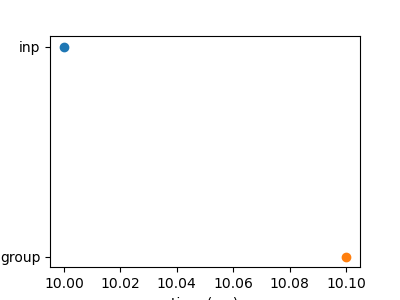

In [2]:
start_scope()

inp = SpikeGeneratorGroup(1, [0], [10]*ms)

group = NeuronGroup(1, 'dv/dt = -v / (20*ms) : 1',
                    threshold='v > 1', reset='v = 0', method='exact')

syn = Synapses(inp, group, on_pre='v_post += 2')
syn.connect()

inp_mon = SpikeMonitor(inp)
group_mon = SpikeMonitor(group)

run(20*ms)

fig, ax = plt.subplots()
ax.plot(inp_mon.t/ms, [1], 'o')
ax.plot(group_mon.t/ms, [0], 'o')
ax.set(yticks=[0, 1], yticklabels=['group', 'inp'], xlabel='time (ms)');

As we can see in the above plot, the target neuron spikes one time step (i.e., by default 0.1ms) later than what we intended. The reason for this is the scheduling of the operations:

In [3]:
magic_network.schedule

['start', 'groups', 'thresholds', 'synapses', 'resets', 'end']

At the 10ms time step, the `SpikeGeneratorGroup` will generate a spike in the `thresholds` slot, which then gets propagated to the target neuron in the `synapses` slot. This, however, basically ends the time step, the target neuron will only spike in the following time step when our schedule reaches the `thresholds` slot again.

To fix this, we might consider to change the order of operations in the schedule. We can do this easily by assigning to the `schedule` attribute:

In [4]:
# we swap synapses and thresholds
magic_network.schedule = ['start', 'groups', 'synapses', 'thresholds', 'resets', 'end']

Does this fix our issue? Let's run the simulation again:

<IPython.core.display.Javascript object>


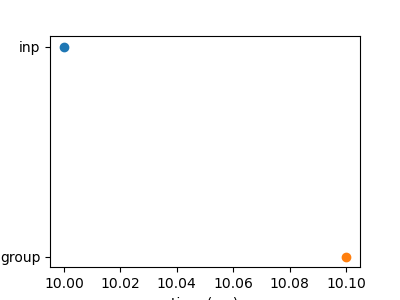

In [5]:
start_scope()

inp = SpikeGeneratorGroup(1, [0], [10]*ms)

group = NeuronGroup(1, 'dv/dt = -v / (20*ms) : 1',
                    threshold='v > 1', reset='v = 0', method='exact')

syn = Synapses(inp, group, on_pre='v_post += 2')
syn.connect()

inp_mon = SpikeMonitor(inp)
group_mon = SpikeMonitor(group)

run(20*ms)

fig, ax = plt.subplots()
ax.plot(inp_mon.t/ms, [1], 'o')
ax.plot(group_mon.t/ms, [0], 'o')
ax.set(yticks=[0, 1], yticklabels=['group', 'inp'], xlabel='time (ms)');

As we can see, nothing changed... This should actually not come as much of a surprise: in the current schedule, the `SpikeGeneratorGroup` will spike in the 10ms time step, but the activity gets only propagated to the target neuron in the time step that follows! We can also confirm this by looking at our trusted `scheduling_summary` function:

In [6]:
scheduling_summary()

object,part of,Clock dt,when,order,active
neurongroup_1_stateupdater (StateUpdater),neurongroup_1 (NeuronGroup),100. us (every step),groups,0,yes
synapses_1_pre (SynapticPathway),synapses_1 (Synapses),100. us (every step),synapses,-1,yes
neurongroup_1_thresholder (Thresholder),neurongroup_1 (NeuronGroup),100. us (every step),thresholds,0,yes
spikegeneratorgroup_1 (SpikeGeneratorGroup),spikegeneratorgroup_1 (SpikeGeneratorGroup),100. us (every step),thresholds,0,yes
spikemonitor (SpikeMonitor),spikemonitor (SpikeMonitor),100. us (every step),thresholds,1,yes
spikemonitor_2 (SpikeMonitor),spikemonitor_2 (SpikeMonitor),100. us (every step),thresholds,1,yes
neurongroup_1_resetter (Resetter),neurongroup_1 (NeuronGroup),100. us (every step),resets,0,yes


Before we continue, let us fix a minor ugliness in the output of `scheduling_summary`. Brian uses names for each of its objects, but these names are determined automatically and can be hard to link back to the code. For example, which of the `SpikeMonitor`s corresponds to `spikemonitor` and `spikemonitor_2`?

To make this link more obvious, we can give our own names to objects by specifying their `name` argument. A useful choice is to simply chose the same name as for the variable in which we store the object:

In [7]:
start_scope()

inp = SpikeGeneratorGroup(1, [0], [10]*ms, name='inp')

group = NeuronGroup(1, 'dv/dt = -v / (20*ms) : 1',
                    threshold='v > 1', reset='v = 0', method='exact',
                    name='group')

syn = Synapses(inp, group, on_pre='v_post += 2', name='syn')
syn.connect()

inp_mon = SpikeMonitor(inp, name='inp_mon')
group_mon = SpikeMonitor(group, name='group_mon')

run(20*ms)

With the `name` definitions, the `scheduling_summary` output becomes more readable

In [8]:
scheduling_summary()

object,part of,Clock dt,when,order,active
group_stateupdater (StateUpdater),group (NeuronGroup),100. us (every step),groups,0,yes
syn_pre (SynapticPathway),syn (Synapses),100. us (every step),synapses,-1,yes
group_thresholder (Thresholder),group (NeuronGroup),100. us (every step),thresholds,0,yes
inp (SpikeGeneratorGroup),inp (SpikeGeneratorGroup),100. us (every step),thresholds,0,yes
group_mon (SpikeMonitor),group_mon (SpikeMonitor),100. us (every step),thresholds,1,yes
inp_mon (SpikeMonitor),inp_mon (SpikeMonitor),100. us (every step),thresholds,1,yes
group_resetter (Resetter),group (NeuronGroup),100. us (every step),resets,0,yes


Now, back to our problem: how to we make the target neuron spike in the same time step as the `SpikeGeneratorGroup`? We cannot simply change the global schedule, as this will move both the `group_thresholder` (which determines when `group` spikes) and the `SpikeGeneratorGroup` around. Instead, we will have to move only one of the two operations around. We can do this by specifying the `when` attribute, which determines into which slot an operation goes. For example, we can use `before_synapses` (see [the first notebook for *Getting the timing right*](https://briansimulator.org/posts/2020/video-scheduling-1/)) slot for the `SpikeGeneratorGroup`:

<IPython.core.display.Javascript object>


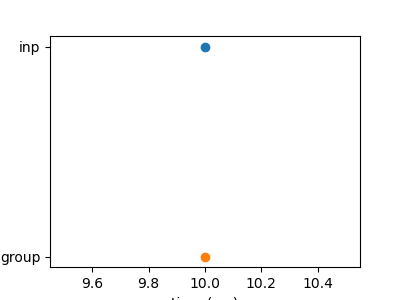

In [9]:
start_scope()

inp = SpikeGeneratorGroup(1, [0], [10]*ms, name='inp', when='before_synapses')

group = NeuronGroup(1, 'dv/dt = -v / (20*ms) : 1',
                    threshold='v > 1', reset='v = 0', method='exact',
                    name='group')

syn = Synapses(inp, group, on_pre='v_post += 2', name='syn')
syn.connect()

inp_mon = SpikeMonitor(inp, name='inp_mon')
group_mon = SpikeMonitor(group, name='group_mon')

run(20*ms)

run(20*ms)

fig, ax = plt.subplots()
ax.plot(inp_mon.t/ms, [1], 'o')
ax.plot(group_mon.t/ms, [0], 'o')
ax.set(yticks=[0, 1], yticklabels=['group', 'inp'], xlabel='time (ms)');

Finally, things work as intended, and we make our target neuron spike at 10ms! Of course, the change is reflected in the schedule:

In [10]:
scheduling_summary()

object,part of,Clock dt,when,order,active
group_stateupdater_1 (StateUpdater),group (NeuronGroup),100. us (every step),groups,0,yes
inp (SpikeGeneratorGroup),inp (SpikeGeneratorGroup),100. us (every step),before_synapses,0,yes
inp_mon (SpikeMonitor),inp_mon (SpikeMonitor),100. us (every step),before_synapses,1,yes
syn_pre (SynapticPathway),syn (Synapses),100. us (every step),synapses,-1,yes
group_thresholder_1 (Thresholder),group (NeuronGroup),100. us (every step),thresholds,0,yes
group_mon (SpikeMonitor),group_mon (SpikeMonitor),100. us (every step),thresholds,1,yes
group_resetter_1 (Resetter),group (NeuronGroup),100. us (every step),resets,0,yes


For more information on this topic, have a look at Brian's [<i class="fas fa-book"></i>&nbsp;documentation](https://brian2.readthedocs.io/en/stable/user/running.html#scheduling)